## Proyección de variables
### Análisis de Componentes Principales (PCA)

#### Idea detrás de PCA
PCA busca proyectar los datos en un espacio lineal (de menor dimensión), llamado *subespacio principal*, tal que la varianza en los datos proyectados sea máxima. 

En otras palabras, busco las direcciones donde los datos presentan mayor variabilidad, y proyecto los datos sobre esas direcciones.

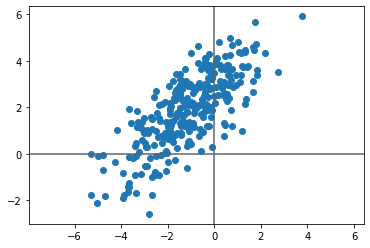

In [1]:
import numpy as np
import matplotlib.pyplot as plt
z = np.random.multivariate_normal(mean = np.array([-1,2]), cov=np.array([[2,.7*2],[0.7*2,2]]),size=300)
plt.scatter(z[:,0],z[:,1])
plt.axhline(color='xkcd:slate grey')
plt.axvline(color='xkcd:slate grey')
plt.xlim(-7,5)
plt.ylim(-5,8)

plt.axis('equal');

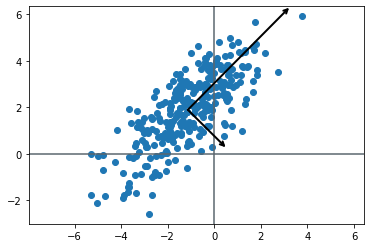

In [2]:
plt.scatter(z[:,0],z[:,1])
plt.xlim(-7,5)
plt.ylim(-5,8)
plt.axhline(color='xkcd:slate grey')
plt.axvline(color='xkcd:slate grey')

from sklearn.decomposition import PCA

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

pca = PCA(n_components = 2).fit(z)

for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
#plt.xlim(-7,5)  

#plt.ylim(-5,8);
plt.axis('equal');

#### ¿Cómo encontramos las direcciones de máxima varianza?

##### Idea de demostración:
Supongamos que tenemos una matriz $\mathbf{X} \in \mathbb{R}^{n\times p}$ una matriz de $n$ observaciones de $p$ variables (i.e. cada columna es un feature y cada fila una muestra). Buscamos hallar las $m\leq p$ direcciones que maximicen la varianza de las muestras. 

Primero hallamos $\boldsymbol{\alpha_1} \in \mathbb{R}^n$ tq. $\boldsymbol{\alpha_1}^T \mathbf{X}$ sea máximo sujeto a $\boldsymbol{\alpha_1}^T \boldsymbol{\alpha_1}=1$

Luego buscamos $\boldsymbol{\alpha_2}\in \mathbb{R}^n$ tq. $\boldsymbol{\alpha_2}^T \mathbf{X}$ sea máximo sujeto a $\boldsymbol{\alpha_2}^T \boldsymbol{\alpha_2}=1$ y además $\boldsymbol{\alpha_2}^T \mathbf{X}$ esté descorrelacionado con $\boldsymbol{\alpha_1}^T \mathbf{X}$, i.e. $\boldsymbol{\alpha_2} \perp \boldsymbol{\alpha_1}$.

Se prosigue de la misma forma hasta hallar los $m$ vectores $\boldsymbol{\alpha_1},\ldots,\boldsymbol{\alpha_m}$.

Notar que por definición la matriz $\boldsymbol{\alpha}_m = \left[ \boldsymbol{\alpha_1}\ \ldots\ \boldsymbol{\alpha_m}\right]$ es ortonormal, y por lo tanto define una matriz de proyección. 

Definiendo $\tilde{\Sigma} = (\mathbf{X}-\bar{\mathbf{X}})^T(\mathbf{X}-\bar{\mathbf{X}})$ la matriz de covarianza muestral, los $\boldsymbol{\alpha_i}$ están asociados a los $m$ primeros autovectores de $\tilde{\Sigma}$.

Al ser $\tilde{\Sigma}$ simétrica,
$$\tilde{\Sigma} = \mathbf{V} \mathbf{S} \mathbf{V}^T,$$
donde $\mathbf{S} = diag(\lambda_1,\ldots,\lambda_p)$ con $\lambda_1\geq\ldots\geq\lambda_p$ los autovalores de $\tilde{\Sigma}$, y $\mathbf{V} = [\mathbf{v}_1, \ldots, \mathbf{v}_p]$ con $\mathbf{v}_i$ el autovector asociado a $\lambda_i$. 


Se concluye que $\boldsymbol{\alpha}_m = \mathbf{V}_m$, donde $\mathbf{V}_m =[ \mathbf{v}_1,\ldots,\mathbf{v}_m]$ 

Los datos transformados resultan $\mathbf{\hat{X}} = \mathbf{X} \mathbf{V}_m$

#### Implementación Paso a paso con un ejemplo sencillo

In [3]:
import numpy as np

$X$ es una matriz de $n$ filas por $p$ columnas donde cada columna representa una feature o característica y cada fila una muestra.

$$
X =
\begin{bmatrix}
x_{11} & x_{12} &  ... & x_{1p} \\
x_{21} & x_{22} &  ... & x_{2p} \\
... & ... &  ... & ... \\
x_{n1} & x_{n2} &  ... & x_{np} \\
\end{bmatrix}
$$

In [4]:
X = np.array([
  [1,2],
  [3,4],
  [5,6]
])
X

array([[1, 2],
       [3, 4],
       [5, 6]])

1) Calcular el promedio de cada columna.

In [5]:
X_mean = np.mean(X,axis=0)
X_mean

array([3., 4.])

2) Centrar cada columna substrayendo su media calculada en el paso anterior.

In [6]:
X_std = X - X_mean
X_std

array([[-2., -2.],
       [ 0.,  0.],
       [ 2.,  2.]])

3) Calcular la matriz de covarianza. 
Explicar: ¿porqué se calcula el transpuesto?

In [7]:
X_cov = np.cov(X_std.T)
X_cov

array([[4., 4.],
       [4., 4.]])

4) Obtener los autovalores y autovectores de la matriz de covarianza.

In [8]:
values, vectors = np.linalg.eig(X_cov)
values

array([8., 0.])

In [9]:
vectors

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

5) Finalmente, calcular el espacio reducido proyectando sobre los autovectores.

In [10]:
X_red = vectors.T.dot(X_std.T)
X_red.T

array([[-2.82842712,  0.        ],
       [ 0.        ,  0.        ],
       [ 2.82842712,  0.        ]])

Finalmente, se puede implementar lo anterior en una clase similar a las que presenta Scikit Learn.


In [11]:
class MyPCA:
  def __init__(self, n_components = None):
    self.components_ = None
    self.X_mean = None
    self.n_components_ = n_components
    pass

  def fit(self,X):
    self.X_mean = X.mean(axis=0)
    X_std = X - self.X_mean
    X_cov = np.cov(X_std.T) # X^T X
    _, self.components_ = np.linalg.eig(X_cov)

    if self.n_components_:
        self.components_ = self.components_[:,:self.n_components_]
  def transform(self,X):    
    return (X-self.X_mean).dot(self.components_)

#### Comparación de resultado con scikit-learn

In [12]:
from sklearn.decomposition import PCA

sk_pca = PCA()
my_pca = MyPCA()

In [13]:
sk_pca.fit(X)
my_pca.fit(X)

In [14]:
sk_pca.components_

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

In [15]:
my_pca.components_

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [16]:
sk_pca.transform(X)

array([[-2.82842712e+00,  2.22044605e-16],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 2.82842712e+00, -2.22044605e-16]])

In [17]:
my_pca.transform(X)

array([[-2.82842712,  0.        ],
       [ 0.        ,  0.        ],
       [ 2.82842712,  0.        ]])

In [18]:
assert(
    np.all(
        np.isclose(
            sk_pca.transform(X), 
            my_pca.transform(X)
        )
    )
)

#### Veamos que pasa con un caso más interesante

Veamos que ocurre cuando queremos aplicar PCA al dataset MNIST. El mismo contiene imágenes de dígitos del 0 al 9, escritos a mano. 
Para ello vamos a descargar el dataset de la página OpenML, usando la función $\texttt{fetch}$_$\texttt{openml}$ de Scikit-Learn

In [19]:
from sklearn.datasets import fetch_openml
digits = fetch_openml("mnist_784")
#print(digits.data.shape)

<Figure size 432x288 with 0 Axes>

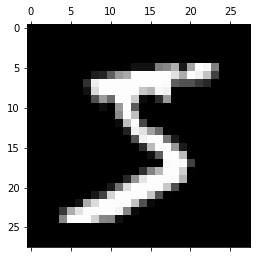

In [20]:
(1797, 64)
import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.data.iloc[0].values.reshape((28,28)))
plt.show() 

In [21]:
pca_MNIST = PCA()
pca_MNIST.fit(digits.data.values)
print(pca_MNIST.components_.shape)

(784, 784)


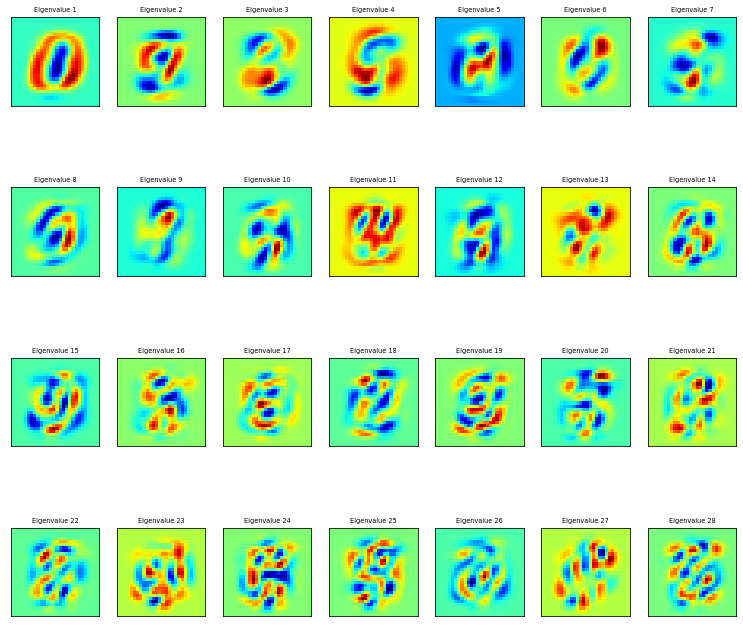

In [22]:
n_row = 4
n_col = 7

# Plot the first 8 eignenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(pca_MNIST.components_[i].reshape(28,28), cmap='jet')
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())

#### Criterios de selección del orden.

Una pregunta importante es cómo elijo la cantidad $m$ de features a retener. Existen dos enfoques comúnmente usados:
- Busco explicar el k% de la varianza de los datos: $m$  es tal que $\frac{\sum_{i=1}^m \sigma_i}{\sum_{i=1}^p \sigma_i}100 > k$
- Método del codo ('elbow'). Grafico los $\sigma_i$ y tomo $m$  en el punto de inflexión de la curva.

Esto se puede ver con el atributo $\texttt{explained_variance_ratio_}$

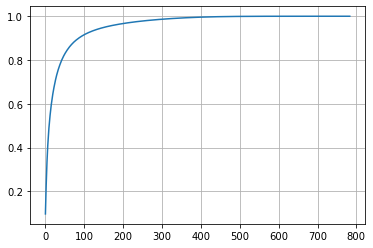

In [23]:
plt.plot(np.cumsum(pca_MNIST.explained_variance_ratio_)); plt.grid(True);

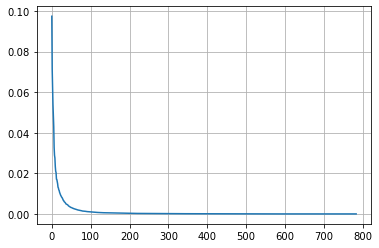

In [24]:
plt.plot(pca_MNIST.explained_variance_ratio_); plt.grid(True);

#### Conclusiones

- **Ventajas**:
    - Obtengo features descorrelacionados
    - No "tiro" información de ninguna variable
    - Explicable en términos de la matriz de correlación
    - No supervisado (sirve para mayor cantidad de problemas)
    
- **Desventajas**:
    - Si el dataset es muy grande puede ser muy costoso de computar
    - Pierdo explicabilidad de los features (ahora son una c.l. de las mediciones)

- **Observaciones**:
    Las direcciones de los componentes principales se pueden ver afectadas por las unidades de medida, por ejemplo un feature es la altura en metros de una persona y otra el peso en gramos). Una práctica común estandarizar las variables para que tengan media 0 y varianza 1 antes de aplicar PCA.

### Descomposición en Valores Singulares (SVD)

La descomposición en valores singulares es muy popular para reducir dimensiones para datos *sparse* (datos donde gran cantidad de los features tiene valor nulo para cada medición). 

Recordemos un poco la SVD. Tenemos $\mathbf{X} \in \mathbb{R}^{n\times p}$ una matriz de $n$ observaciones de $p$ variables. Luego, $\mathbf{X}$ se puede descomponer como 

$$\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T,$$

donde $\mathbf{U}\in\mathbb{R}^{n\times n}$, $\mathbf{V}\in\mathbb{R}^{p\times p}$ y $\mathbf{\Sigma} \in \mathbb{R}^{n\times p}$ es una matriz "diagonal"
     
![SVDdiagram.png](SVDdiagram.png)

Análogamente a lo que se hizo para PCA, para reducir las dimensiones podemos proyectar los datos sobre las primeras $k$ columnas de $\mathbf{V}$
$$\hat{\mathbf{X}} = \mathbf{X}\mathbf{V_k},$$
donde $\mathbf{V}_k = [\mathbf{v}_1, \ldots, \mathbf{v}_k]$

#### Implementación paso a paso
 

$\mathbf{X}$ es una matriz de $n$ filas por $p$ columnas donde cada columna representa una feature o característica y cada fila una muestra.

$$
\mathbf{X} =
\begin{bmatrix}
x_{11} & x_{12} &  ... & x_{1p} \\
x_{21} & x_{22} &  ... & x_{2p} \\
... & ... &  ... & ... \\
x_{n1} & x_{n2} &  ... & x_{np} \\
\end{bmatrix}
$$

In [25]:
import numpy as np
from scipy.linalg import svd

In [26]:
X = np.array([
  [1,2,3,4,5,6,7,8,9,10],
  [11,12,13,14,15,16,17,18,19,20],
  [21,22,23,24,25,26,27,28,29,30]
])
X

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]])

1) Calculo la descomposición en valores singulares (SVD) de la matriz de datos $\mathbf{X}$, obteniendo $\mathbf{U}$, $\mathbf{\Sigma}$, $\mathbf{V}$

In [27]:
U, s, Vt = svd(X)

2) Observo los valores singulares, s para elegir la cantidad de dimensiones a elegir

In [28]:
s

array([9.69657342e+01, 7.25578339e+00, 1.48879510e-15])

3) Retengo las $k$ dimensiones más relevantes, y reduzco las diemensiones de las matrices para hallar $\mathbf{U}_k$, $\mathbf{\Sigma}_k$, $\mathbf{V}_k$

In [29]:
k = 2
s= s[:k]
Vt = Vt[:k,:]
U = U[:,:k]

4) Puedo observar la versión "recuperada" de $\mathbf{X}$, y hallo los datos transformados $\mathbf{T} = \mathbf{X}\mathbf{V}_k$ 

In [30]:
X_red = U.dot(np.diag(s).dot(Vt))
X_red

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [11., 12., 13., 14., 15., 16., 17., 18., 19., 20.],
       [21., 22., 23., 24., 25., 26., 27., 28., 29., 30.]])

In [31]:
T = X.dot(Vt.T) # seria como el PCA pero sobre los datos sin centrar.
T

array([[-18.52157747,  -6.47697214],
       [-49.81310011,  -1.91182038],
       [-81.10462276,   2.65333138]])

Nuevamente, podemos implementar una clase con nuestra versión de SVD

In [32]:
class mySVD:
    def __init__(self, n_components = None):
        self.U = None
        self.s = None
        self.V = None
        self.n_components = n_components
        pass
    def fit(self, X):
        n,p = X.shape
        self.U, self.s, self.V = svd(X)
        self.U = self.U[:,:min(n,p)]
        self.V = self.V[:min(n,p)].T
        if self.n_components:
            self.U = self.U[:,:self.n_components]
            self.V = self.V[:,:self.n_components]
            self.s = self.s[:self.n_components]
        pass
            
    def transform(self, X):
        return X.dot(self.V)
        

#### Comparación de resultado con scikit-learn

In [33]:
from sklearn.decomposition import TruncatedSVD
my_svd = mySVD(2)
my_svd.fit(X)
sk_svd = TruncatedSVD(2).fit(X)


In [34]:
my_svd.transform(X)

array([[-18.52157747,  -6.47697214],
       [-49.81310011,  -1.91182038],
       [-81.10462276,   2.65333138]])

In [35]:
sk_svd.transform(X)

array([[18.52157747,  6.47697214],
       [49.81310011,  1.91182038],
       [81.10462276, -2.65333138]])

In [36]:
assert(
    np.any(
        [np.all(
            np.isclose(
                sk_svd.transform(X), 
                my_svd.transform(X)
            )
        ),
        np.all(
            np.isclose(
                -sk_svd.transform(X), 
                my_svd.transform(X)
            )
        )]
    )
)
# agego comparación con el negado porque SVD tiene el problema de "sign indeterminacy"

### ¿Qué representan las matrices $\mathbf{U}$ y $\mathbf{V}$? 

$\mathbf{U}$ se corresponde  con los autovectores de $\mathbf{X}\mathbf{X}^T$, mientras $\mathbf{V}$ está asociada a los avutovectores de $\mathbf{X}^T\mathbf{X}$ y $\mathbf{\Sigma}$ se corresponde con la raíz cuadrada de lo autovalores de ambas matrices. Lo interesante, es que $\mathbf{X}^T\mathbf{X}$ es la correlación empírica de los features, mientras que $\mathbf{X}\mathbf{X}^T$ es la correlación empírica entre muestras. 

#### Pongamos un ejemplo
La siguiente matriz representa la puntuación de distintos usuarios a 5 películas <sup>[1]</sup>.

![matriz_pelis.png](matriz_pelis.png)

En este caso, la descomposición en valores singulares resulta

$$\begin{array}{c c c c c}
\left[\begin{smallmatrix} 1& 1&1&0&0\\ 3&3&3&0&0\\ 4&4&4&0&0 \\ 5&5&5&0&0 \\ 0&0&0&4&4\\0&0&0&5&5\\0&0&0&2&2 \end{smallmatrix}\right] & = & \left[\begin{smallmatrix} 0.14 & 0\\ 0.42&0\\0.56&0\\0.7&0\\0&0.6\\0&0.75\\0&0.3\end{smallmatrix}\right] & \left[\begin{smallmatrix}12.4&0\\0&9.5 \end{smallmatrix}\right] & \left[\begin{smallmatrix} 0.58 &0.58 & 0.58 &0&0\\0&0&0&0.71&0.71\end{smallmatrix}\right]\\
\mathbf{X} & & \mathbf{U} & \mathbf{\Sigma} & \mathbf{V}^T
\end{array}$$

¿Qué observamos?
La matriz $\mathbf{U}$ conecta personas a tópicos ("ciencia ficción", y "románticas"), mientras que $\mathbf{V}$ conecta películas a tópicos. De esta forma, nos separa las distintas películas en categorías, y separa a los usuarios según categorías de películas. La matriz $\mathbf{\Sigma}$ nos devuelve la intensidad de cada conceptos. En este caso, como más usuarios ratearon películas de ciencia ficción, esta categoría tiene  mayor peso.

En general, las categorías van a estar cruzadas, por ejemplo alguien que ve mayormente películas románticas puede haber visto Matrix. En este caso vamos a tener mayor cantidad de valores singulares positivos. Lo que se hace es descartar aquellos valores singulares significativamente más pequeños que el resto.


### Comentarios:
- Realizar la descomposición SVD sobre los datos centrados es equivalente a hacer PCA
- SVD funciona sobre datos sparse, sin necesidad de "redensificarlos" que puede ocupar mucha memoria
- Por cómo se implementa el algoritmo, puede ocurrir que entre distintos entrenamientos (fitteos) se intercambie el signo de los vectores. Una forma de mitigar este inconveniente es entrenando una única vez y luego transformando varias veces. 
- Según el problema, las matrices $\mathbf{U}$ y $\mathbf{V}$ de SVD pueden dar información útil acerca de las correlaciones entre las muestras y las entre las variables.

## Bibliografia:

[1] "Mining of Massive Datasets",  Leskovec J, Rajaraman A., Ullman J.D., Stanford University. Capítulo 11. http://infolab.stanford.edu/~ullman/mmds/ch11.pdf

[2] https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

[3] "Pattern Recognition and Machine Learning", Bishop, Christopher M. New York, Springer, 2006

